# Power Production - Machine Learning project
___

The assignment project for Machine Learning and Statistics, GMIT 2020-2021

Lecturer: Dr. Ian McLoughlin

>Author: **Andrzej Kocielski**  
>Github: [andkoc001](https://github.com/andkoc001/)  
>Email: G00376291@gmit.ie, and.koc001@gmail.com



### Content

```
1. Introduction
2. Wind power
3. Data set - exploaratory analysis
4. Model 1 - simple linear regression
5. Model 2 - polynomial regression
6. Model 3 - random forrest
7. Conclusion
8. References
```


</br>

## Introduction

___

This notebook consists of the project development, research summary, code, etc. It should be read in conjunction with the corresponding README.md file at the project [repository](https://github.com/andkoc001/Machine-Learning-and-Statistics-Project.git) at GitHub.

### Project objectives

The objective of the is to develop a web service to make predictions using Machine Learning (ML) paradigm. 

The goal of the project is to produce a model or models that, based on the provided dataset `powerproduction`, and through applying the appropriate ML techniques, predicts power output generated by wind turbine from wind. The power output predictions should be generated in response to wind speed values to be obtained as HTTP requests.

Further details can be found in the [project brief](https://github.com/andkoc001/Machine-Learning-and-Statistics/blob/main/assessment.pdf).

### Web App

Along with this notebook, the project is constituted by development of an web application. The web app provides an interactive and user friendly tool that allows for testing selected machine learning models. The app returns predicted values of power output, upon user input wind speed. Please refer to the README.md file in this repository for more information.

</br>

## Wind power 
___

Wind power (or wind energy) is a general term describing energy generated from wind, where the wind kinetic enrgy is converted into electrical power. Typically, the power is generated in wind turbins.

There is many factors influencing the generated output, but wind speed is a fundamental contributor. Wikipedia article states that the power is proportional to the third power of the wind speed ([Wind power](https://en.wikipedia.org/wiki/Wind_power)):

$$
P = \frac{1}{2} A \rho v^3
$$

where $P$ is the power output, $A$ corresponds to the size of the turbin, $\rho$ is the air density and $v$ is the wind speed.

However, in practical terms, the observed power output follows a more complex pattern ([Wind education - Wind power](https://energyeducation.ca/encyclopedia/Wind_power)).

![https://qph.fs.quoracdn.net/main-qimg-dab018104232374e846a9e47c7b5434e.webp](https://qph.fs.quoracdn.net/main-qimg-dab018104232374e846a9e47c7b5434e.webp) Image source: ([Quora - What is a power curve](https://www.quora.com/What-is-a-power-curve-and-how-do-we-draw-one))

The wind turbin activates on a certain treshold wind speed - referred as to cut-in speed. Below that speed the turbin operation is not economically viable. 

The maximum power output is achieved at the rated wind speed - turbin specific. In the zone between the cut-in and rated speeds, the power increases exponencially with the wind speed. 

Behind the rated speed, the produced output remains approximately flat (or may decline gently), until it reaches the cut-off speed. At such speed, the turbine is shut down in order to prevent them from taking damege. 

It is also worth noting that the above power curve is only a crude approximation of the observed amount of energy produced in reality. 

</br>

## Data set - exploratory analysis

___

### Importing required libraries

For this project the external packages and modules are used. All of them are imported in the cell(s) below. It is required to import the packages and modules before running the subsequent cells.


In [1]:
# import required libraries and packages - see description above

# ignore deprecated warnings
import warnings
warnings.filterwarnings("ignore")

# calculating square root
from math import sqrt

# numerical operations on arrays
import numpy as np

# data manipulation (dataframe)
import pandas as pd

#  fitting linear regression
from sklearn.linear_model import LinearRegression

# polynomial coefficients
from sklearn.preprocessing import PolynomialFeatures

# split data set into random train and test subsets
from sklearn.model_selection import train_test_split

# random forrest regressor
from sklearn.ensemble import RandomForestRegressor

# for accuracy evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

# plotting 
import matplotlib.pyplot as plt
import seaborn as sns

General plotting settings are defined in the following cell.

In [2]:
# plotting settings

# set plotting style
plt.style.use('ggplot')

# set default figure size
plt.figure(figsize=(14,8))
plt.rcParams["figure.figsize"] = (14,8)

# plot matplotlib graphs next to the code
%matplotlib inline

### Loading the data set from a file

The data set provided for the project is loaded from the file powerproduction.txt (in the repository). It is stored as a DataFrame and assigned under the name `df_raw`.

In [3]:
# load the data set from file
df_raw = pd.read_csv(r"powerproduction.txt")

### A glance into the data set

The dataset loaded from the provided file is assigned to variable `df_raw`. Let us take a sneak peek as to how this dataset looks like. We will attempt to evaluate its size, basic statistical properties, distributions, etc. as well as produce some plots for a better understanding of its properties.  

In [4]:
# show the data set
# df_raw # commented out not to clutter the notebook

In [5]:
# rudimentary statistical insight into the data set
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
speed,500.0,12.590398,7.224991,0.0,6.32475,12.5505,18.77525,25.000
power,500.0,48.014584,41.614572,0.0,5.28800,41.6455,93.53700,113.556


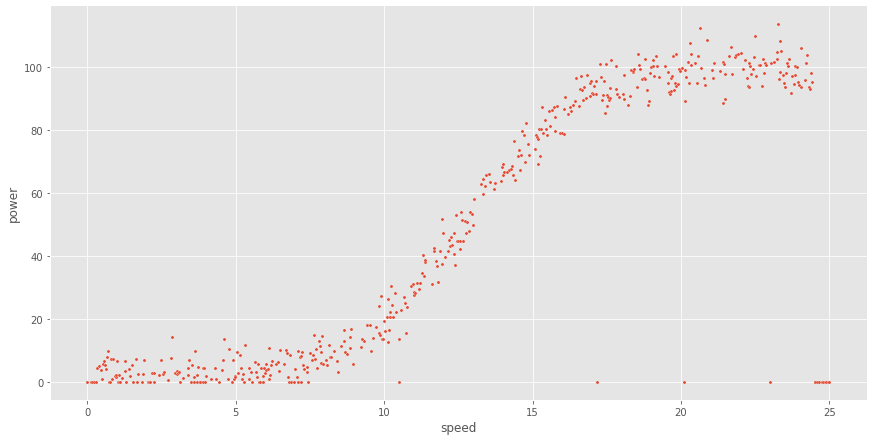

In [6]:
# plot the data points
sns.relplot(data=df_raw, x="speed", y="power", s=10, height=6, aspect=2)

The analysis of the wind speed distribution shows that the wind speed appears to uniformly distribute, with no particular wind speed dominating.

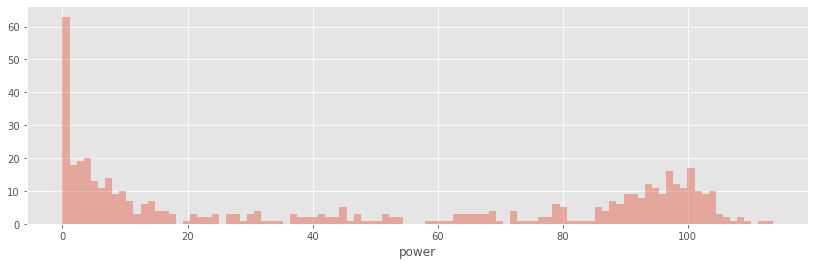

In [7]:
# Histogram of power outputs - frequency of occurance - 'zero' values seem to distort the plot
plt.rcParams["figure.figsize"] = (14,4)
sns.distplot(df_raw.power, bins=100, kde=False)
plt.show()

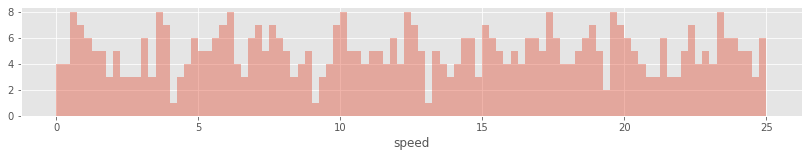

In [8]:
# what wind speeds dominate - it appears to be more or less uniformely distributed
plt.rcParams["figure.figsize"] = (14,2)
sns.distplot(df_raw.speed, bins=100, kde=False)
plt.show()

### Exploratory data analysis

From the above dataset description and data points plot, the following conclusions can be drawn.

The data set consist of 500 observations (rows). Each observation consists of 2 attributes (columns): wind speed (`speed`) and corresponding power output (`power`). The units of the values are not explicitly given. Possibly the wind speed is shown in m/s, whereas power values represents the turbin efficiency.

The wind speed values varies from 0 to 25 and are shown in ascending order. Every speed value is unique. The power output values varies from 0 to 113.556. There are 49 instances (approximatelly 10% of all observations) where the power output equals zero.

From the plot one can observe three distinct areas with different behaviour of the data points. I will refer to them as zones A, B, C and D.

A - The wind speed ranging from 0 to about 8.  
B - In wind speed range from about 8 to about 17.  
C - The wind speed between approximately 17 and 24.5.  
D - Above wind speed level of 24.5.

Such a behaviour agrees closely with the wind power curve shown above ([Wind education - Wind power](https://energyeducation.ca/encyclopedia/Wind_power)). It can be explained by the fact that at low wind speed - in zone A - the wind does not carry sufficient energy to turn the turbines or it is not economically justified. The genreated power output readings are not affected by the wind speed in this region. These readings may be caused by other factors (noise). For this analyis, however, it is assumed these are valid output readings.  
In zone B there is a nearly linear (even close to exponencial) correlation between the wind speed and the power output.  
When wind speed exceeds approximately 17, the wind turbines work with a high performance, close to its 100% efficiency. However, the power output declines slightl with incrasing wind speed, up to approximately 24.5 - zone C.  
In the zone D where the winds are very strong, the power output is not produced. The power generation abruptly ceases, possibly because the turbines are shut off for safety reasons.

(-5.0, 120.0)

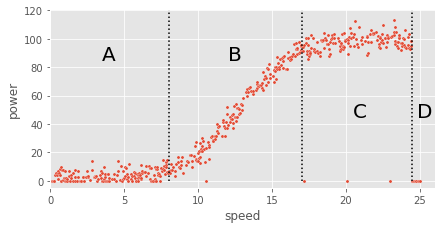

In [9]:
sns.relplot(data=df_raw, x="speed", y="power", s=10, height=3, aspect=2)
plt.plot([8,8],[0,120], "k:")
plt.plot([17,17],[0,120], "k:")
plt.plot([24.5,24.5],[0,120], "k:")
plt.text(3.5, 85, "A", size='20', color='black')
plt.text(12, 85, "B", size='20', color='black')
plt.text(20.5, 45, "C", size='20', color='black')
plt.text(24.8, 45, "D", size='20', color='black')
plt.xlim(0,26)
plt.ylim(-5,120)

### Noise and erroneous readings

Based on the research and my own professional expertise, the data set is clearly affected by some random noise, as the readings show a consistent erratic behavior. It is assumed thera are other factors in play which are not identified, and yet influence the reading. 

The study show that wind turbines do not normally generate any output untill it reaches 'cut-in' treshold. However, in the provided data set some low speed resulted in production of electricity. Similarly, power outputs going significantly above its full capacity should not be considered accurate. These readings could be results of [measurement errors](https://www.statisticshowto.com/measurement-error/).

Also, there occasional observations where the power output is zero, even though the wind speeds are in zones allowing for producing the power. In total, there is 49 observations with power output equal to zero. It is assumed these data points represent observations during, for example, maintenance works, when the turbin was shut down.


### Clean the dataset

The observations where the power output is zero spread randomly along the wind speeds. The data points seem to distort data set. These points are therefore assumed to be data anomaly and excluded from further analysis.

The data set is now cleand by removal of these observations from the dataset. A new dataframe `df` is created.

In [10]:
# clean the dataset by removing distorting observations

# remove the observations where wind speed is less than 6 and the power output greated than 5 - these readings are considered affected by noise
df = df_raw.drop(df_raw.loc[(df_raw.power > 5) & (df_raw.speed < 4)].index)

# remove the observations where wind speed greater than 10 and power output is zero - these are considered errous readings (e.g. due to maintenance)
df = df.drop(df.loc[(df.power == 0) & (df.speed > 10)].index)

# remove the observations where wind power output is greater than 110 - these are considered errous readings (noise)
df = df.drop(df.loc[(df.power > 110)].index)

In [11]:
# number of removed observations after cleaning
df_raw.shape[0] - df.shape[0]

35

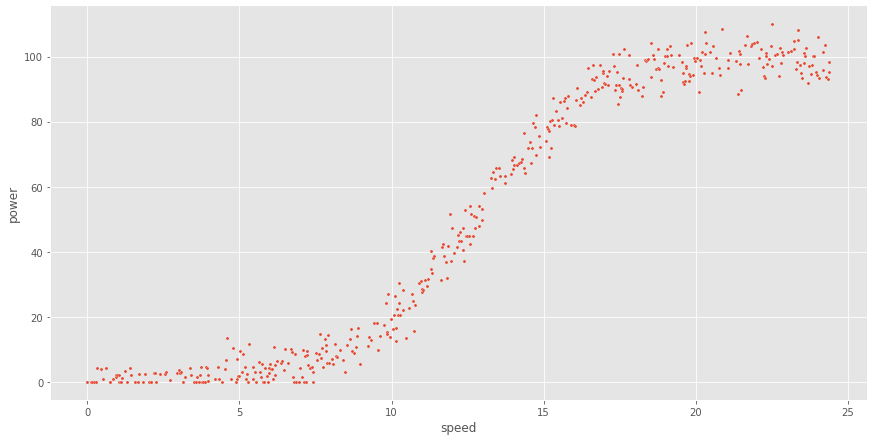

In [12]:
# plot the data points
sns.relplot(data=df, x="speed", y="power", s=10, height=6, aspect=2)

### The problem

In terms of the machine learning, wind speed to power output relationship constitutes a regression problem. The objective of this project is to apply machine learning techniques in order to forecast a responce of the power output (independent variable) based on a given wind speed (dependent variable). The provided data set is composed out of two variables (features). As the variables are continues in nature (in contrast to categorical) and unlabeled, the task requires application of unsupervised learning ([Real Python - Linear Regression in Python](https://realpython.com/linear-regression-in-python/)). 

</br>

## Simple linear regression

___

Simple linear regression is one of the simplest supervised learning algorithms in machine learning and is widely used for forecasting. The aim of the linear regression is  to fit a stight line to the data ([https://en.wikipedia.org/wiki/Linear_regression](https://en.wikipedia.org/wiki/Linear_regression)). In this section, sklearn library is used. This section of the project is based on [Alaettin Serhan Mete - Linear regression - exercise project](https://amete.github.io/DataSciencePortfolio/Udemy/Python-DS-and-ML-Bootcamp/Linear_Regression_Project.html).

The entire data set is first devided into variable `X` that holds the wind speed values and a variable `y` equal to the power outputs. Next, the data is split into training and testing sets. The training set is formed out of 70% random instances from the whole (cleaned) data set and the test data - out of remaing 30%. 

A linear regression model, called `lin_reg_model`, is built and trained on the training sets X and y.

In [13]:
# assign "speed" and "power" sets to variables X and y
X, y = df["speed"], df["power"]

# random_state (seed) is set for consistancy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

In [14]:
# convert the array shape and unify the lengths
X_train = X_train.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)

# create an instance of a LinearRegression() model named lin_reg_model.
lin_reg_model = LinearRegression()

#Train/fit lin_reg_model on the training data.
lin_reg_model.fit(X_train, y_train)

LinearRegression()

### Model evaluation

Let's see the model parameters: the coefficient and intercept. The meaning of the model coefficient is that for each x-value increase by 1, the predicted response increases by coefficient. The intercept is the value where the regression line crosses the y-axis.

In [15]:
# coefficient of the model (slope)
print(f"The model coefficient (slope) is {float(lin_reg_model.coef_):.2f}")

# intercept value
print(f"Intercept: {float(lin_reg_model.intercept_):.1f}")

The model coefficient (slope) is 5.74
Intercept: -22.2


### Prediction

Prediction of the test values will allow to evaluate the model's performance. 

Function `predict()` is used to predict the `X_test` set of the data. Then, the predictions of the test values will be ploted against the real test values versus.

In [16]:
# reschape X_test
X_test = X_test.values.reshape(-1,1)

predictions = lin_reg_model.predict(X_test)

(-20.0, 120.0)

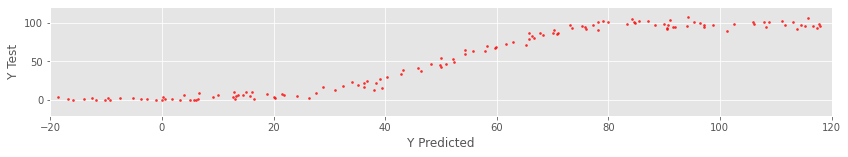

In [17]:
# plot the results
plt.scatter(predictions, y_test, s=4, color='red', alpha=.8)
plt.xlabel('Y Predicted')
plt.ylabel('Y Test')
plt.rcParams["figure.figsize"] = (8,8)
plt.xlim(-20,120)
plt.ylim(-20,120)

In [18]:
# take a random wind speed value from the provided data set (cleaned)
wind_test = df["speed"].sample()

# link corresponding actual power output
for i in range(df.shape[0]):
    if df.iloc[i]["speed"] == wind_test.iloc[0]:
        actual_output = df.iloc[i]["power"]
        
power_predict = lin_reg_model.predict([wind_test])
print(f"The predicted power output for wind speed {float(wind_test):.3f} is: \t {float(power_predict):.3f}")
print(f"The actual power output for wind speed {float(wind_test):.3f} is: \t {float(actual_output):.3f}")
print(f"The prediction accuracy for the data point is: \t\t {float(abs(1.-(abs(power_predict-actual_output)/actual_output))*100):.1f}%")

The predicted power output for wind speed 1.552 is: 	 -13.309
The actual power output for wind speed 1.552 is: 	 0.000
The prediction accuracy for the data point is: 		 inf%


In [19]:
# accuracy of the test set
predictions = predictions.flatten()

print(f"Root mean square error (RMSE): {mean_squared_error(y_test, predictions, squared=False):.2f}") # (by hand: {sqrt((1./len(y_test))*(sum((y_test-predictions)**2))):.2f})")
print(f"Coefficient of determination (R square): {r2_score(y_test, predictions):.2f}") # true value, predicted value

Root mean square error (RMSE): 13.14
Coefficient of determination (R square): 0.90


### Conclusion

Simple linear regression (first polynomial order), offers only a crude approximation. The accuracy for the given data set is resonable only in some limited ranges of wind speed. The simple linear regressiong should be used with much care as the results may be grossly wrong. The model can even yield a negative power output from certain wind speeds! 

</br>

## Polynomial regression

___

Better results, when comparing to simple linear regression, can be produced from higher order polynomial regressions. I have tried various polynomial orders of regression from 1st up to 15th order. Some of them are shown in below plot. Even though regression of lower polynomial are still suseptible to underfitting approximation, they appear to be significantly better simple linear regression. At the same time, higher polynomial order regression tend to excessive complexity and may lead to the risk of overfitting.

Several polynomials of various order has been tested. The 7th order seems to provide a good accuracy in the wind speed between 0 and 24.5, as shown below in solid blue line.

In [20]:
# reshape the array
X = df.iloc[:, 0].values.reshape(-1,1)
# y = df.iloc[:, 1].values.reshape(-1,1)
y = df.iloc[:, 1]

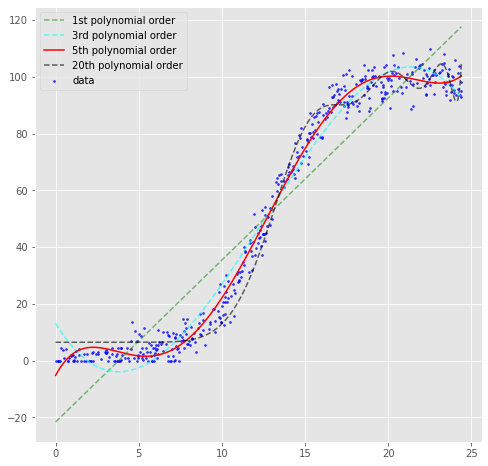

In [21]:
# adapted from https://stackoverflow.com/q/51732577
plt.scatter(X, y, s=4, color='blue', alpha=0.8, label="data")

# Fitting Polynomial Regression to the dataset
poly_reg = PolynomialFeatures(degree = 1)
X_poly = poly_reg.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
plt.plot(X, lin_reg.predict(X_poly), ls="--", color = 'green', alpha=0.5, label='1st polynomial order')

poly_reg = PolynomialFeatures(degree = 3)
X_poly = poly_reg.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
plt.plot(X, lin_reg.predict(X_poly), ls="--", color='cyan', alpha=0.6, label='3rd polynomial order')

poly_reg = PolynomialFeatures(degree = 5)
X_poly = poly_reg.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
plt.plot(X, lin_reg.predict(X_poly), ls="-", color='red', alpha=1.0, label='5th polynomial order')

poly_reg = PolynomialFeatures(degree = 20)
X_poly = poly_reg.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
plt.plot(X, lin_reg.predict(X_poly), ls="--", color='black', alpha=.6, label='20th polynomial order')

# Visualising the Polynomial Regression results
plt.legend(loc='best')
plt.rcParams["figure.figsize"] = (14,8)
plt.show()

### Apply regression model

This section is based on tutorial at [Miroslaw Mamczur - Jak działa regresja liniowa i czy warto ją stosować (in Polish)](https://miroslawmamczur.pl/jak-dziala-regresja-liniowa-i-czy-warto-ja-stosowac/). Again, sklearn package id used to built the regression model. This time, the regression model is develope on the entire data set, without splitting for training and test sets.

The polynomial order=7 appears to closely follow the pattern of the data points in the domain of the wind speed (range 0-24.5). It also appears to be free from overfitting in this range. Therefore I consider it a good candidate for further analysis.

In [22]:
# develop a regression model
poly = PolynomialFeatures(degree = 7) # 7th polynomial order
X_poly = poly.fit_transform(X)
# lin_reg = LinearRegression()
# ask our model to fit the data.
# lin_reg.fit(X_poly, y)
poly_reg = LinearRegression().fit(X_poly, y)
# perform regression to predict the power output out of wind speed
y_pred = poly_reg.predict(X_poly)

print('Coefficients: ', poly_reg.coef_)
print('Intercept: ', poly_reg.intercept_)

Coefficients:  [ 0.00000000e+00 -9.25381441e+00  6.48184708e+00 -1.73542743e+00
  2.19520315e-01 -1.35529643e-02  4.01514498e-04 -4.59439083e-06]
Intercept:  4.265712712579351


Out of curiosity, I have also compared the polynomial coefficients when applying the Numpy's `polyfit()`. This function gets the value of the coefficients that minimise the squared order of the polynomial function. The coefficients and the intercept are the same as those achieved using the sklearn library above.

In [23]:
coeff = np.polyfit(df['speed'], df['power'], 7)
#coeff
yp = np.poly1d(coeff)

print("y = ")
print(yp)

y = 
            7             6           5          4         3         2
-4.594e-06 x + 0.0004015 x - 0.01355 x + 0.2195 x - 1.735 x + 6.482 x - 9.254 x + 4.266


### Predictions

In order to predict the power output in function of the wind speed, the above equation will be used. In the below cell, enter manually wind speed (in the range 0-25) to get the model to calculate the power output.

In [24]:
# enter arbitrary wind speed value in range between 0 and 25
wind_speed = 20

x = wind_speed
power_output = (-5.11800967e-06*pow(x,7)) + 4.48301902e-04*pow(x,6) - 1.52309426e-02*pow(x,5) + 2.50368085e-01*pow(x,4) - 2.04365136e+00*pow(x,3) + 8.13376871e+00*pow(x,2) - 1.38470256e+01*pow(x,1) + 10.91407191*pow(x,0)
print(f"Predicted power output from wind speed = {wind_speed} is: {power_output:.2f}")

Predicted power output from wind speed = 20 is: 98.42


### Accuracy

(-20.0, 120.0)

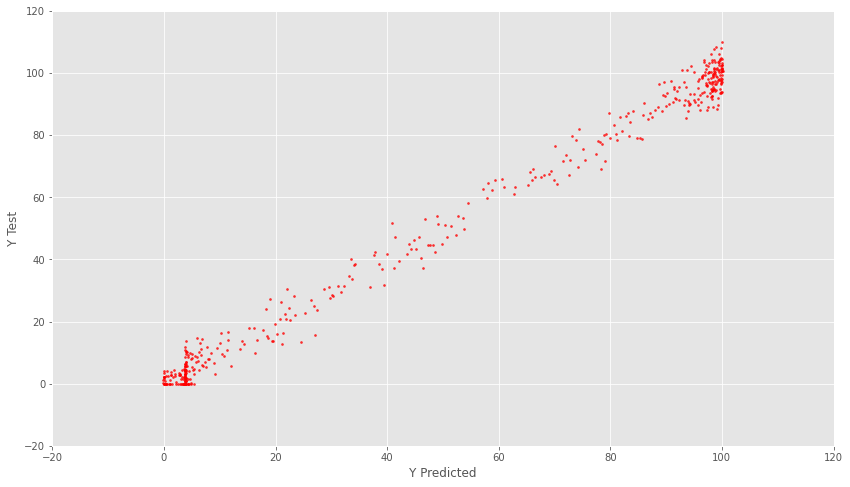

In [25]:
# plot the results
plt.scatter(y_pred, y, s=4, color='red', alpha=.8)
plt.xlabel('Y Predicted')
plt.ylabel('Y Test')
plt.rcParams["figure.figsize"] = (8,8)
plt.xlim(-20,120)
plt.ylim(-20,120)

In [26]:
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y, y_pred)):.2f}")
print(f"Coefficient of determination (R square): {r2_score(y, y_pred):.2f}") # true value, predicted value

Root Mean Squared Error (RMSE): 3.91
Coefficient of determination (R square): 0.99


From the above metrics the most important are root mean squared error, being a way to measure the error of a model in predicting quantitative data, and the coefficient of determination. The achieved value of $RMSE=4.05$ is low, suggesting a good model. Also $R^2 = 0.99$ is very close to 1, meaning it is a good fit for the data points.

### Conclusion

Polynomial regressions provide a distinctly better approximation than simple linear regression. The above shown 7th order polynomial gives accurate results and the model does not show overfitting in the considered wind speeds range.

</br>

## Random Forrest

___

...


In [27]:
# reshape the subset arrays
# X_train = X_train.values.reshape(-1, 1) # already reshaped for previous model
# y_train = y_train.values
# X_test = X_test.values.reshape(-1, 1)

In [28]:
# https://www.geeksforgeeks.org/random-forest-regression-in-python/

# Fitting Random Forest Regression to the dataset 
# import the regressor 
from sklearn.ensemble import RandomForestRegressor 
  
# create an instance of the random forrest model
rand_forr_model = RandomForestRegressor(n_estimators = 100, random_state = 2020) 
  
# fit the regressor with the train data subset
rand_forr_model.fit(X_train, y_train) 

RandomForestRegressor(random_state=2020)

In [29]:
test_result = rand_forr_model.predict(X_test) 

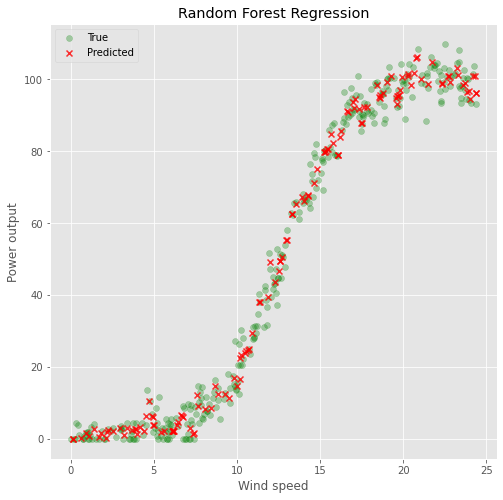

In [30]:
# Scatter plot for original data 
plt.scatter(X_train, y_train, color = 'green', alpha=.3, label='True')   
  
# plot predicted data 
plt.scatter(X_test, test_result, color = 'red', marker='x', alpha=.8, label='Predicted')  

plt.title('Random Forest Regression') 
plt.xlabel('Wind speed') 
plt.ylabel('Power output')
plt.legend(loc='best')
plt.rcParams["figure.figsize"] = (14,8)
plt.show()

In [37]:
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, test_result)):.2f}")
print(f"Coefficient of determination (R square): {r2_score(y_test, test_result):.2f}") # true value, predicted value

Root Mean Squared Error (RMSE): 4.76
Coefficient of determination (R square): 0.99


</br>  

## Conclusions

---

- Data set - needs preprocessing (cleaning)
- There are many ML algorithms. Selected for this project were: simple linear regression, polynomial regression, random forrest.
- The accuracy achieved from the models applied in the project are shown in the below table.

|            Model            | RMSE  | R square |
|:---------------------------:|-------|----------|
| Simple linear regression    | 13.14 | 0.90     |
| Polynomial regression (5th) | 3.91  | 0.99     |
| Random forrest              | 4.76  | 0.99     |

- All ML algorithms have pros and cons. The application of a specific model may vary significantly in terms of complexity or accuracy
- ML models cannot be applied blindly - much care must be taken when selecting the optimal one and implementing it.
- The interpretation of the results is, as usual, the difficult part. The expertise in the field of application may promote successful implementation.

</br>  

## References 

---

This project is based predominantly on the lecture materials - not explicitly quoted in the body of the notebook.


#### Wind Power

- [001] [Wikipedia - Wind power](https://en.wikipedia.org/wiki/Wind_power)
- [002] [Wind power - How to calculate power output of wind](https://www.windpowerengineering.com/calculate-wind-power-output)
- [003] [Energy education - Wind power](https://energyeducation.ca/encyclopedia/Wind_power)
- [004] [Wind works - wind turbine rating](http://www.wind-works.org/cms/index.php?id=85&tx_ttnews%5Btt_news%5D=2572&cHash=b74148dbab1938159937a994adf1f05b)
- [005] [Vaishali Sohoni - A Critical Review on Wind Turbine Power Curve Modelling Techniques and Their Applications in Wind Based Energy Systems](https://www.hindawi.com/journals/jen/2016/8519785/)

#### Linear regression in Machine Learning

- [001] [Wikipedia - Linear Regression](https://en.wikipedia.org/wiki/Linear_regression)
- [002] [Towards Data Science - Introduction to Machine Learning algorithms: linear regression](https://towardsdatascience.com/introduction-to-machine-learning-algorithms-linear-regression-14c4e325882a)
- [003] [Machine Learning Glossary - Linear regression](https://ml-cheatsheet.readthedocs.io/en/latest/linear_regression.html)
- [004] [Machine Learning Mastery - Linear regression for machine learning](https://machinelearningmastery.com/linear-regression-for-machine-learning/)
- [005] [Scikit-learn documentation - Polynomial regression](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)
- [006] [Miroslaw Mamczur - Jak działa regresja liniowa i czy warto ją stosować (in Polish)](https://miroslawmamczur.pl/jak-dziala-regresja-liniowa-i-czy-warto-ja-stosowac/)
- [007] [Alaettin Serhan Mete - Linear regression - exercise project](https://amete.github.io/DataSciencePortfolio/Udemy/Python-DS-and-ML-Bootcamp/Linear_Regression_Project.html)
- [008] [Real Python - Linear regression in Python](https://realpython.com/linear-regression-in-python/)

#### Random Forrest in Machine Learning

- [001] [Jack Vanderplas - Python data science handbook - decision trees and random forests](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html)
- [002] [Avik Dutta - Random forrest regression in Python](https://www.geeksforgeeks.org/random-forest-regression-in-python/)
- [003] [Will Koehrsen - Random forest in Python](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)



___
Andrzej Kocielski